Using 106 edges


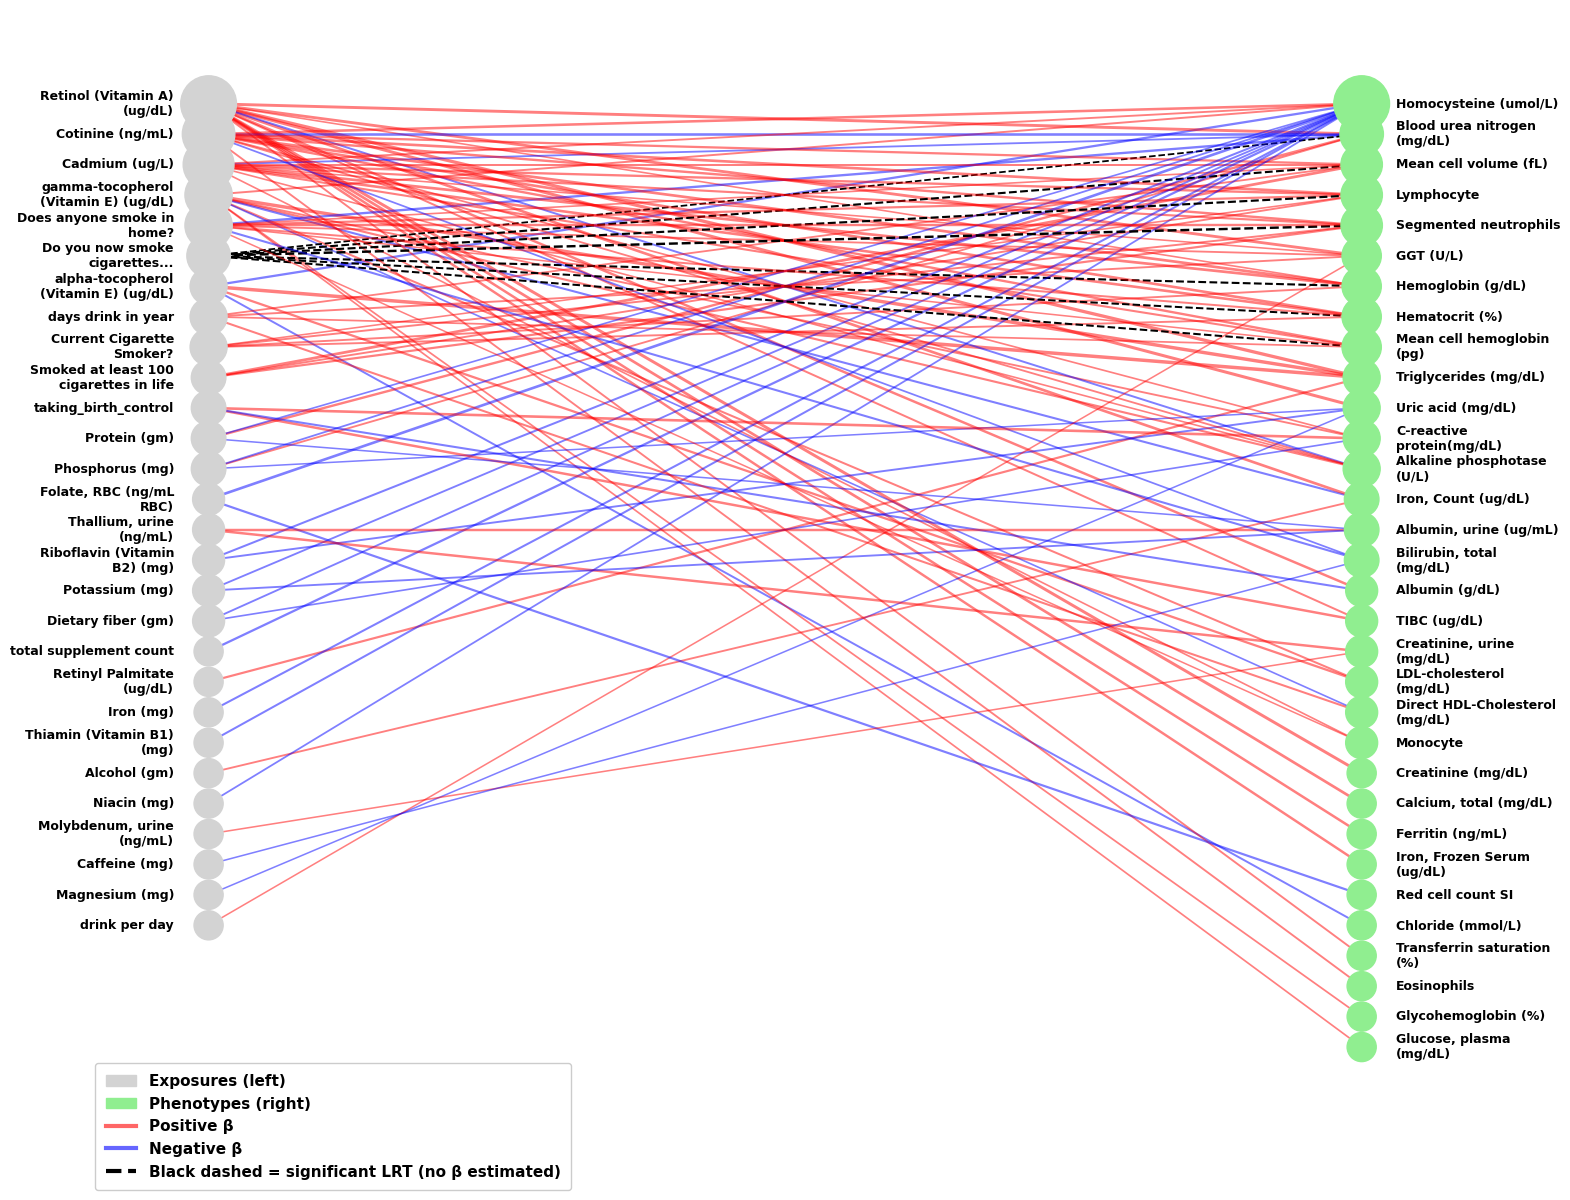

Saved to: /Users/nikkipalmiero/Documents/PhEWAS_manuscript/network_plot_FINAL_black_dotted_LRT_lowopacity.png


In [32]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import textwrap

# ========= 1. LOAD + CLEAN DATA =========

path = "/Users/nikkipalmiero/Documents/PhEWAS_manuscript/network_table.csv"
df = pd.read_csv(path)

df = df.rename(columns=lambda c: c.strip().replace(" ", "_"))

# Remove word "number"
df["Phenotype"] = (
    df["Phenotype"]
        .str.replace(r"\bnumber\b", "", case=True, regex=True)
        .str.replace("  ", " ")
        .str.strip()
)

# Filter significant replicated associations
sig = df[df["Replication_FDR"] < 0.05].copy()
sig["edge_weight"] = -np.log10(sig["Replication_Raw_pvalue"])
sig = sig.sort_values("edge_weight", ascending=False).head(106)

print(f"Using {sig.shape[0]} edges")

# ========= 2. BUILD GRAPH =========

G = nx.Graph()

for _, row in sig.iterrows():
    exp = row["Exposure"]
    pheno = row["Phenotype"]
    beta = row.get("Replication_Beta", np.nan)

    G.add_node(exp, bipartite="exposure")
    G.add_node(pheno, bipartite="phenotype")

    G.add_edge(
        exp, pheno,
        beta=beta,
        p=row["Replication_Raw_pvalue"],
        fdr=row["Replication_FDR"],
        weight=row["edge_weight"]
    )

# ========= 3. DEGREE + SORTING =========

deg = dict(G.degree())

exposures   = [n for n, d in G.nodes(data=True) if d["bipartite"] == "exposure"]
phenotypes  = [n for n, d in G.nodes(data=True) if d["bipartite"] == "phenotype"]

exposure_sorted  = sorted(exposures,  key=lambda n: deg[n], reverse=True)
phenotype_sorted = sorted(phenotypes, key=lambda n: deg[n], reverse=True)

pos = {}
pos.update({n: (0, -i) for i, n in enumerate(exposure_sorted)})
pos.update({n: (1, -i) for i, n in enumerate(phenotype_sorted)})

# ========= 4. EDGE STYLE SETUP (initial placeholders) =========

edge_colors = []
edge_styles = []
weights = []

for u, v in G.edges():
    beta = G[u][v].get("beta", np.nan)
    w = G[u][v]["weight"]
    weights.append(w)

    if pd.isna(beta) or beta == 0:
        edge_colors.append("black")
        edge_styles.append("dotted")
    elif beta > 0:
        edge_colors.append("red")
        edge_styles.append("solid")
    else:
        edge_colors.append("blue")
        edge_styles.append("solid")

max_w = max(weights)
edge_widths = [0.5 + 2*(w/max_w) for w in weights]

# ========= 5. NODE SIZES =========

exp_sizes   = [350 + 90*deg[n] for n in exposure_sorted]
pheno_sizes = [350 + 90*deg[n] for n in phenotype_sorted]

# ========= 6. LABEL WRAPPING =========

def wrap_label(s, width=22):
    return "\n".join(textwrap.wrap(s, width=width))

labels = {n: wrap_label(n) for n in G.nodes()}

# ========= 7. PLOT =========

plt.figure(figsize=(16, 12))

# Exposure nodes
nx.draw_networkx_nodes(
    G, pos,
    nodelist=exposure_sorted,
    node_color="lightgray",
    node_size=exp_sizes,
    node_shape="o"
)

# Phenotype nodes (light green)
nx.draw_networkx_nodes(
    G, pos,
    nodelist=phenotype_sorted,
    node_color="lightgreen",
    node_size=pheno_sizes,
    node_shape="o"
)

# ========= EDGES (black dotted LRT, red/blue less opaque) =========

for (u, v), color, style, width in zip(G.edges(), edge_colors, edge_styles, edge_widths):

    beta = G[u][v].get("beta", np.nan)

    # LRT-only → black dotted, full alpha
    if pd.isna(beta) or beta == 0:
        color = "black"
        style = "dashed"
        alpha = 1.0
    else:
        # Positive/negative edges less opaque
        alpha = 0.5

    nx.draw_networkx_edges(
        G, pos,
        edgelist=[(u, v)],
        edge_color=color,
        width=width,
        style=style,
        alpha=alpha
    )

# ========= LABELS (close: ±0.03) =========

for n, (x, y) in pos.items():
    lbl = labels[n]

    if n in exposure_sorted:
        plt.text(
            x - 0.03, y, lbl,
            fontsize=9, fontweight="bold",
            ha='right', va='center'
        )
    else:
        plt.text(
            x + 0.03, y, lbl,
            fontsize=9, fontweight="bold",
            ha='left', va='center'
        )

plt.axis("off")

# ========= LEGEND =========

exposure_patch  = mpatches.Patch(color="lightgray",  label="Exposures (left)")
phenotype_patch = mpatches.Patch(color="lightgreen", label="Phenotypes (right)")
pos_line        = mlines.Line2D([], [], color="red",  linewidth=3, alpha=0.6, label="Positive β")
neg_line        = mlines.Line2D([], [], color="blue", linewidth=3, alpha=0.6, label="Negative β")
lrt_line        = mlines.Line2D([], [], color="black", linewidth=3, linestyle="dashed",
                                label="Black dashed = significant LRT (no β estimated)")

legend = plt.legend(
    handles=[exposure_patch, phenotype_patch, pos_line, neg_line, lrt_line],
    loc="lower left",
    bbox_to_anchor=(0.00, -0.05),
    fontsize=11,
    frameon=True,
    fancybox=True,
    framealpha=1,
    borderpad=0.7
)

for text in legend.get_texts():
    text.set_fontweight("bold")

plt.tight_layout()

# ========= SAVE =========

save_path = "/Users/nikkipalmiero/Documents/PhEWAS_manuscript/network_plot_FINAL_black_dotted_LRT_lowopacity.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved to:", save_path)


Using 106 edges


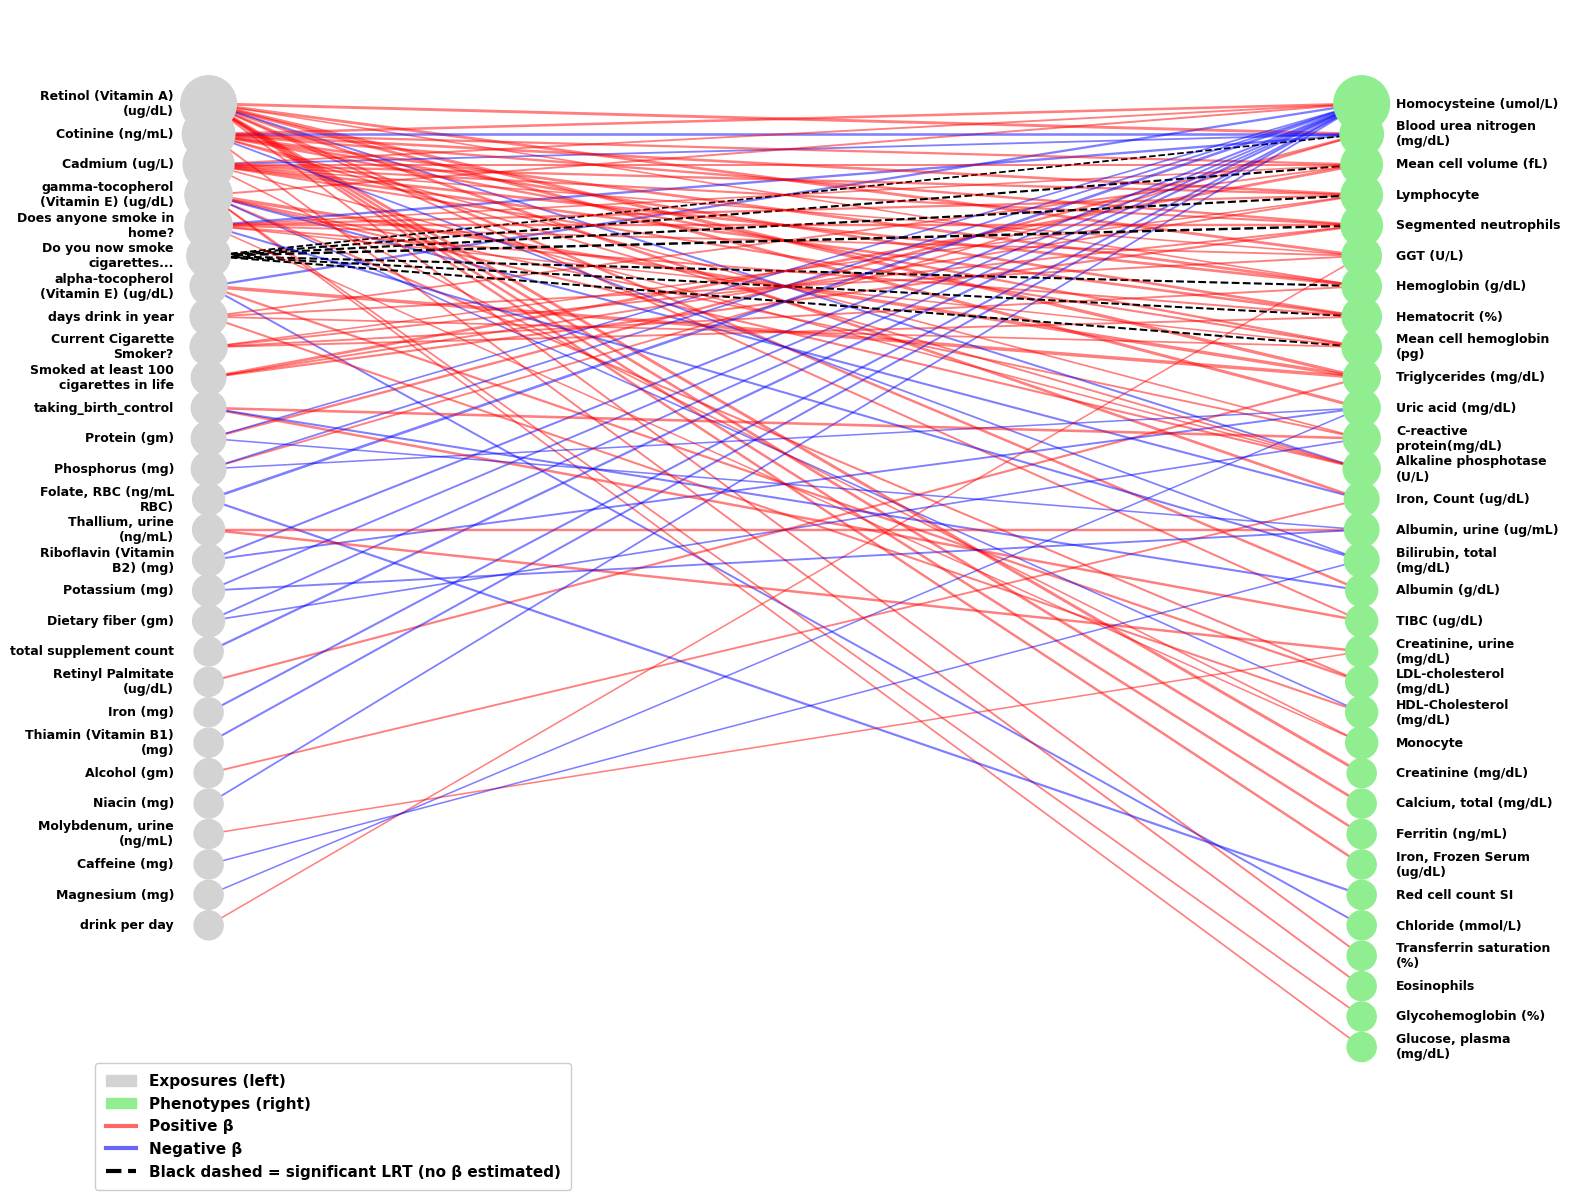

Saved to: /Users/nikkipalmiero/Documents/PhEWAS_manuscript/network_plot_FINAL_black_dotted_LRT_lowopacity.png


In [40]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import textwrap

# ========= 1. LOAD + CLEAN DATA =========

path = "/Users/nikkipalmiero/Documents/PhEWAS_manuscript/network_table.csv"
df = pd.read_csv(path)

df = df.rename(columns=lambda c: c.strip().replace(" ", "_"))

# Clean phenotype names: remove “number” and “Direct”
df["Phenotype"] = (
    df["Phenotype"]
        .str.replace(r"\bnumber\b", "", case=True, regex=True)
        .str.replace(r"\bDirect\b", "", case=True, regex=True)
        .str.replace(r"\bdirect\b", "", case=True, regex=True)
        .str.replace("  ", " ")
        .str.strip()
)

# Filter significant replicated associations
sig = df[df["Replication_FDR"] < 0.05].copy()
sig["edge_weight"] = -np.log10(sig["Replication_Raw_pvalue"])
sig = sig.sort_values("edge_weight", ascending=False).head(106)

print(f"Using {sig.shape[0]} edges")

# ========= 2. BUILD GRAPH =========

G = nx.Graph()

for _, row in sig.iterrows():
    exp = row["Exposure"]
    pheno = row["Phenotype"]
    beta = row.get("Replication_Beta", np.nan)

    G.add_node(exp, bipartite="exposure")
    G.add_node(pheno, bipartite="phenotype")

    G.add_edge(
        exp, pheno,
        beta=beta,
        p=row["Replication_Raw_pvalue"],
        fdr=row["Replication_FDR"],
        weight=row["edge_weight"]
    )

# ========= 3. DEGREE + SORTING =========

deg = dict(G.degree())

exposures   = [n for n, d in G.nodes(data=True) if d["bipartite"] == "exposure"]
phenotypes  = [n for n, d in G.nodes(data=True) if d["bipartite"] == "phenotype"]

exposure_sorted  = sorted(exposures,  key=lambda n: deg[n], reverse=True)
phenotype_sorted = sorted(phenotypes, key=lambda n: deg[n], reverse=True)

pos = {}
pos.update({n: (0, -i) for i, n in enumerate(exposure_sorted)})
pos.update({n: (1, -i) for i, n in enumerate(phenotype_sorted)})

# ========= 4. EDGE STYLE SETUP =========

edge_colors = []
edge_styles = []
weights = []

for u, v in G.edges():
    beta = G[u][v].get("beta", np.nan)
    w = G[u][v]["weight"]
    weights.append(w)

    if pd.isna(beta) or beta == 0:
        edge_colors.append("black")
        edge_styles.append("dotted")
    elif beta > 0:
        edge_colors.append("red")
        edge_styles.append("solid")
    else:
        edge_colors.append("blue")
        edge_styles.append("solid")

max_w = max(weights)
edge_widths = [0.5 + 2*(w/max_w) for w in weights]

# ========= 5. NODE SIZES =========

exp_sizes   = [350 + 90*deg[n] for n in exposure_sorted]
pheno_sizes = [350 + 90*deg[n] for n in phenotype_sorted]

# ========= 6. LABEL WRAPPING =========

def wrap_label(s, width=22):
    return "\n".join(textwrap.wrap(s, width=width))

labels = {n: wrap_label(n) for n in G.nodes()}

# ========= 7. PLOT =========

plt.figure(figsize=(16, 12))

# Exposure nodes
nx.draw_networkx_nodes(
    G, pos,
    nodelist=exposure_sorted,
    node_color="lightgray",
    node_size=exp_sizes,
    node_shape="o"
)

# Phenotype nodes (light green)
nx.draw_networkx_nodes(
    G, pos,
    nodelist=phenotype_sorted,
    node_color="lightgreen",
    node_size=pheno_sizes,
    node_shape="o"
)

# ========= EDGES: black dashed for LRT; red/blue for +/− β =========

for (u, v), color, style, width in zip(G.edges(), edge_colors, edge_styles, edge_widths):

    beta = G[u][v].get("beta", np.nan)

    if pd.isna(beta) or beta == 0:
        color = "black"
        style = "dashed"
        alpha = 1.0
    else:
        alpha = 0.5

    nx.draw_networkx_edges(
        G, pos,
        edgelist=[(u, v)],
        edge_color=color,
        width=width,
        style=style,
        alpha=alpha
    )

# ========= LABELS =========

for n, (x, y) in pos.items():
    lbl = labels[n]

    if n in exposure_sorted:
        plt.text(
            x - 0.03, y, lbl,
            fontsize=9, fontweight="bold",
            ha='right', va='center'
        )
    else:
        plt.text(
            x + 0.03, y, lbl,
            fontsize=9, fontweight="bold",
            ha='left', va='center'
        )

plt.axis("off")

# ========= LEGEND =========

exposure_patch  = mpatches.Patch(color="lightgray",  label="Exposures (left)")
phenotype_patch = mpatches.Patch(color="lightgreen", label="Phenotypes (right)")
pos_line        = mlines.Line2D([], [], color="red",  linewidth=3, alpha=0.6, label="Positive β")
neg_line        = mlines.Line2D([], [], color="blue", linewidth=3, alpha=0.6, label="Negative β")
lrt_line        = mlines.Line2D([], [], color="black", linewidth=3, linestyle="dashed",
                                label="Black dashed = significant LRT (no β estimated)")

legend = plt.legend(
    handles=[exposure_patch, phenotype_patch, pos_line, neg_line, lrt_line],
    loc="lower left",
    bbox_to_anchor=(0.00, -0.05),
    fontsize=11,
    frameon=True,
    fancybox=True,
    framealpha=1,
    borderpad=0.7
)

for text in legend.get_texts():
    text.set_fontweight("bold")

plt.tight_layout()

# ========= SAVE =========

save_path = "/Users/nikkipalmiero/Documents/PhEWAS_manuscript/network_plot_FINAL_black_dotted_LRT_lowopacity.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved to:", save_path)


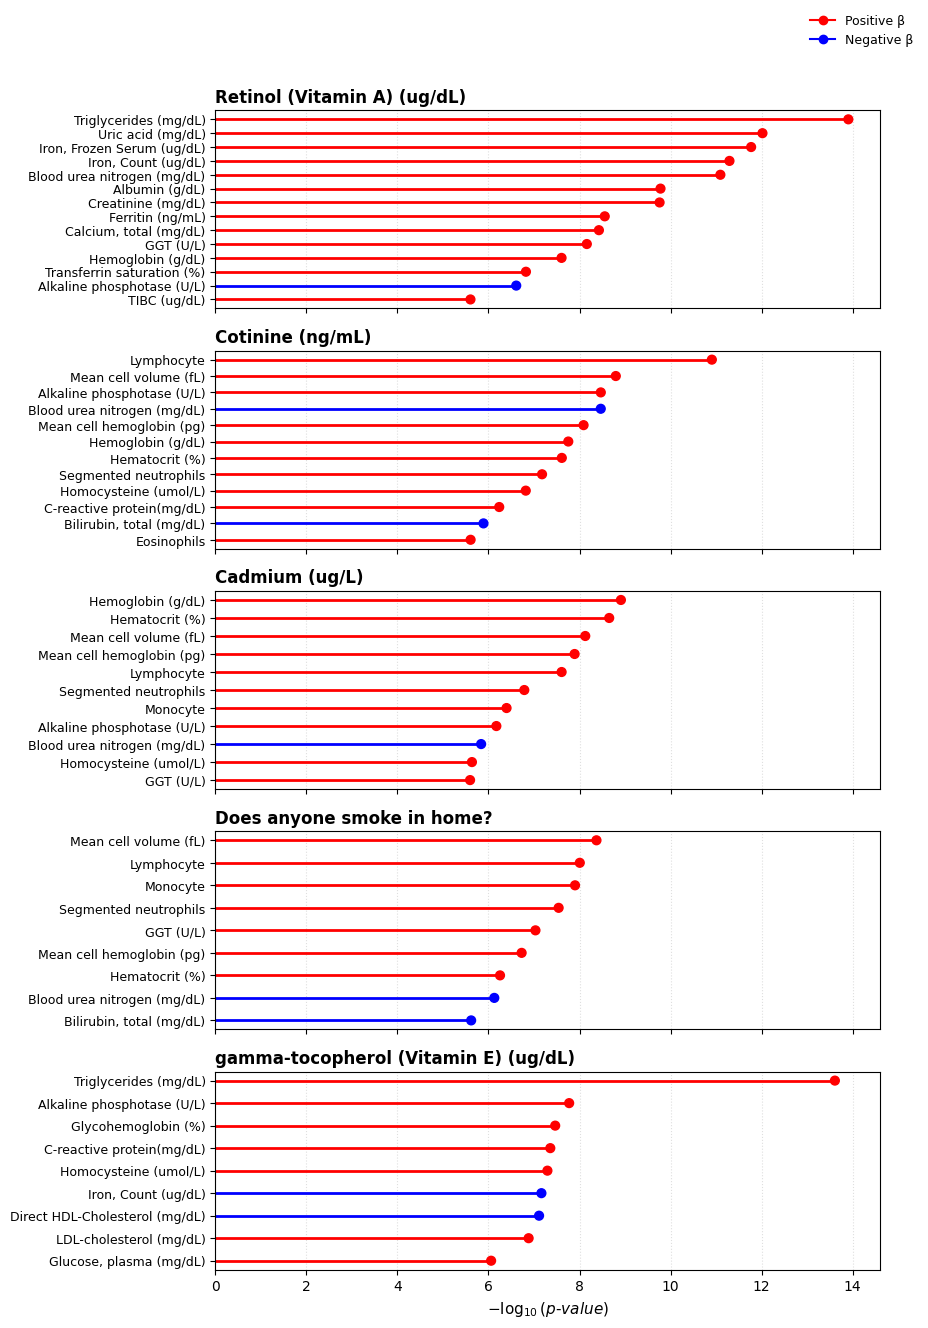

Saved figure: /Users/nikkipalmiero/Documents/PhEWAS_manuscript/lollipop_star_exposures_discovery.png


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap
import matplotlib.lines as mlines

# ========= LOAD DATA =========
path = "/Users/nikkipalmiero/Documents/PhEWAS_manuscript/network_table.csv"
df = pd.read_csv(path)

# Clean column names
df = df.rename(columns=lambda c: c.strip().replace(" ", "_"))

# Clean phenotype names (remove 'number')
df["Phenotype"] = (
    df["Phenotype"]
      .str.replace(r"\bnumber\b", "", case=True, regex=True)
      .str.replace("  ", " ")
      .str.strip()
)

# Only replicated significant associations (same filter as before)
sig = df[df["Replication_FDR"] < 0.05].copy()

# Use DISCOVERY p-values for the x-axis
sig["neglog10_p_disc"] = -np.log10(sig["Discovery_Raw_Pvalue"])

# ========= SELECTED EXPOSURES =========
exposures_of_interest = [
    "Retinol (Vitamin A) (ug/dL)",
    "Cotinine (ng/mL)",
    "Cadmium (ug/L)",
    "Does anyone smoke in home?",
    "gamma-tocopherol (Vitamin E) (ug/dL)"
]

plot_df = sig[sig["Exposure"].isin(exposures_of_interest)].copy()

def wrap_label(s, width=35):
    return textwrap.fill(s, width=width)

# ========= FIGURE =========
n = len(exposures_of_interest)
fig, axes = plt.subplots(
    nrows=n, ncols=1,
    figsize=(10, 2.8 * n),
    sharex=True
)

if n == 1:
    axes = [axes]

for ax, exposure in zip(axes, exposures_of_interest):

    sub = plot_df[plot_df["Exposure"] == exposure].copy()
    if sub.empty:
        ax.set_visible(False)
        continue

    # Sort by DISCOVERY p-value (smallest first)
    sub = sub.sort_values("Discovery_Raw_Pvalue").reset_index(drop=True)
    y_pos = np.arange(len(sub))

    betas = sub["Discovery_Beta"].values if "Discovery_Beta" in sub.columns else sub["Replication_Beta"].values

    colors = np.where(betas > 0, "red",
              np.where(betas < 0, "blue", "black"))
    linestyles = np.where(np.isnan(betas), "dotted",
                   np.where(betas == 0, "dotted", "solid"))

    # stems
    for i_row, (x_val, col, ls) in enumerate(zip(sub["neglog10_p_disc"], colors, linestyles)):
        ax.hlines(y=i_row, xmin=0, xmax=x_val, color=col, linestyle=ls, linewidth=2)

    # dots
    ax.scatter(sub["neglog10_p_disc"], y_pos, c=colors, s=40, zorder=3)

    # y labels
    ax.set_yticks(y_pos)
    ax.set_yticklabels([wrap_label(p) for p in sub["Phenotype"]], fontsize=9)
    ax.invert_yaxis()

    # full exposure name as panel title
    ax.set_title(
        wrap_label(exposure, width=40),
        fontsize=12, fontweight="bold", loc="left"
    )

    ax.grid(axis="x", linestyle=":", alpha=0.4)
    ax.set_axisbelow(True)

# X-axis label and limits
axes[-1].set_xlabel(r"$-\log_{10}(p\text{-}value)$",
                    fontsize=11, fontweight="bold")

max_x = plot_df["neglog10_p_disc"].max()
plt.xlim(0, max_x * 1.05)

# Legend for direction
pos = mlines.Line2D([], [], color="red", marker='o', linestyle='-', label="Positive β")
neg = mlines.Line2D([], [], color="blue", marker='o', linestyle='-', label="Negative β")

fig.legend(handles=[pos, neg],
           loc="upper right", bbox_to_anchor=(0.98, 0.98),
           fontsize=9, frameon=False)

plt.tight_layout(rect=[0.05, 0.03, 0.95, 0.93])

save_path = "/Users/nikkipalmiero/Documents/PhEWAS_manuscript/lollipop_star_exposures_discovery.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved figure:", save_path)


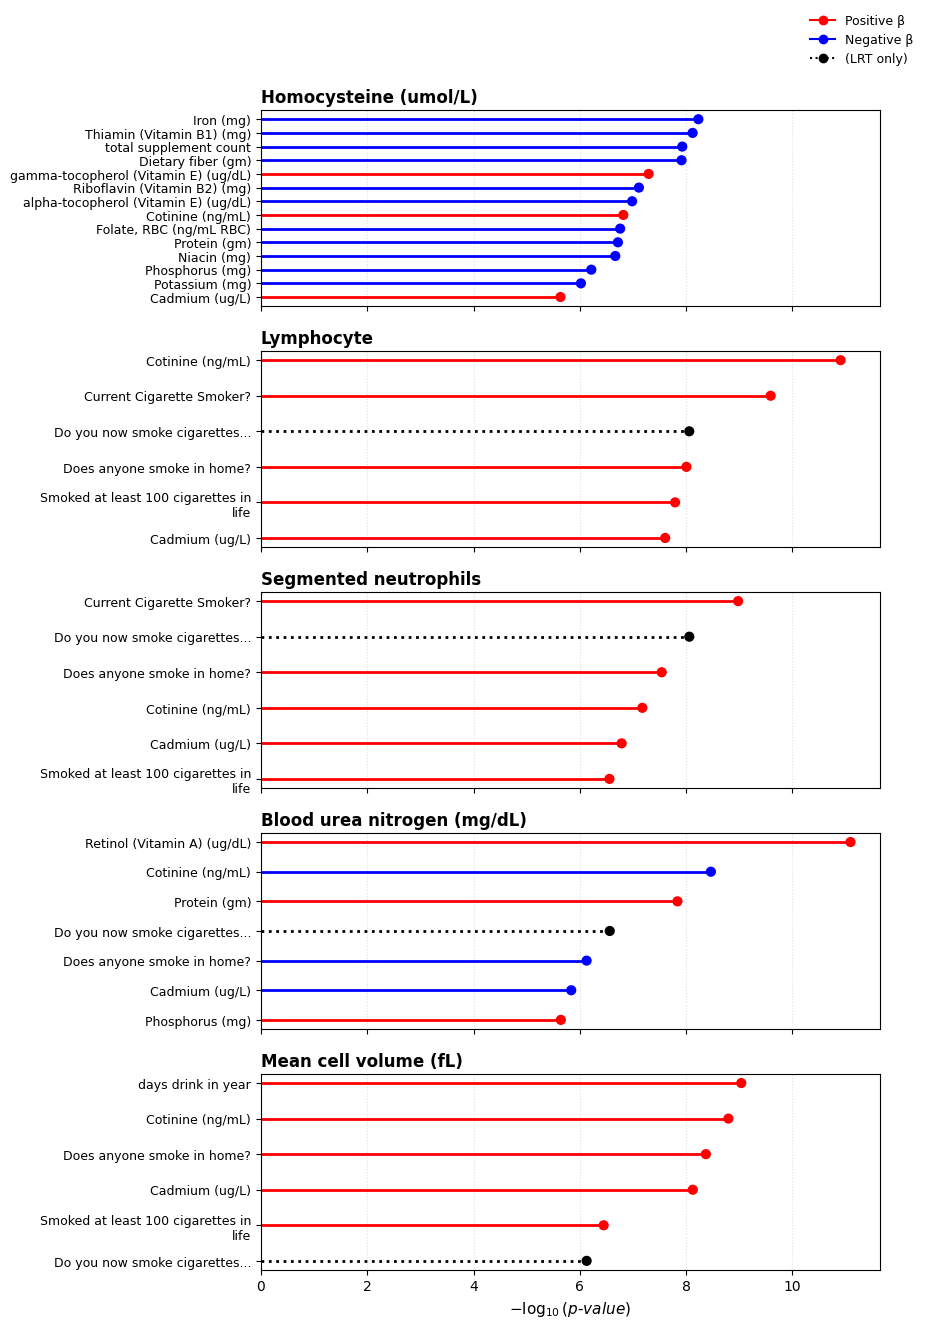

Saved phenotype lollipop figure to: /Users/nikkipalmiero/Documents/PhEWAS_manuscript/lollipop_star_phenotypes_discovery.png


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap
import matplotlib.lines as mlines

# ========= LOAD DATA =========
path = "/Users/nikkipalmiero/Documents/PhEWAS_manuscript/network_table.csv"
df = pd.read_csv(path)

# Clean column names
df = df.rename(columns=lambda c: c.strip().replace(" ", "_"))

# Clean phenotype names (remove 'number')
df["Phenotype"] = (
    df["Phenotype"]
      .str.replace(r"\bnumber\b", "", case=True, regex=True)
      .str.replace("  ", " ")
      .str.strip()
)

# Keep replicated significant results
sig = df[df["Replication_FDR"] < 0.05].copy()

# Use DISCOVERY p-values for x-axis
sig["neglog10_p_disc"] = -np.log10(sig["Discovery_Raw_Pvalue"])

# ========= STAR PHENOTYPES =========
phenotypes_of_interest = [
    "Homocysteine (umol/L)",
    "Lymphocyte",
    "Segmented neutrophils",
    "Blood urea nitrogen (mg/dL)",
    "Mean cell volume (fL)"
]

plot_df = sig[sig["Phenotype"].isin(phenotypes_of_interest)].copy()

def wrap_label(s, width=35):
    return textwrap.fill(s, width=width)

# ========= FIGURE =========
n = len(phenotypes_of_interest)
fig, axes = plt.subplots(
    nrows=n, ncols=1,
    figsize=(10, 2.8 * n),
    sharex=True
)

if n == 1:
    axes = [axes]

# ========= PLOT PANELS =========
for ax, pheno in zip(axes, phenotypes_of_interest):

    sub = plot_df[plot_df["Phenotype"] == pheno].copy()
    if sub.empty:
        ax.set_visible(False)
        continue

    # Sort by discovery p-value
    sub = sub.sort_values("Discovery_Raw_Pvalue").reset_index(drop=True)
    y_pos = np.arange(len(sub))

    # Effect direction colors
    betas = (
        sub["Discovery_Beta"].values
        if "Discovery_Beta" in sub.columns
        else sub["Replication_Beta"].values
    )
    colors = np.where(betas > 0, "red",
              np.where(betas < 0, "blue", "black"))
    linestyles = np.where(np.isnan(betas), "dotted",
                   np.where(betas == 0, "dotted", "solid"))

    # Stems
    for i_row, (x_val, col, ls) in enumerate(zip(sub["neglog10_p_disc"], colors, linestyles)):
        ax.hlines(y=i_row, xmin=0, xmax=x_val, color=col, linestyle=ls, linewidth=2)

    # Dots
    ax.scatter(sub["neglog10_p_disc"], y_pos, c=colors, s=40, zorder=3)

    # ========= LABEL LOGIC HERE =========
    # No wrapping for Homocysteine
    if pheno == "Homocysteine (umol/L)":
        y_labels = sub["Exposure"]  # one-line labels
    else:
        y_labels = [wrap_label(e) for e in sub["Exposure"]]

    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_labels, fontsize=9)
    ax.invert_yaxis()

    # Title = full phenotype name
    ax.set_title(
        wrap_label(pheno, width=40),
        fontsize=12,
        fontweight="bold",
        loc="left"
    )

    ax.grid(axis="x", linestyle=":", alpha=0.4)
    ax.set_axisbelow(True)

# Shared x-axis label
axes[-1].set_xlabel(
    r"$-\log_{10}(p\text{-}value)$",
    fontsize=11,
    fontweight="bold"
)

# X limits
max_x = plot_df["neglog10_p_disc"].max()
plt.xlim(0, max_x * 1.05)

# Legend
pos = mlines.Line2D([], [], color="red", marker='o', linestyle='-', label="Positive β")
neg = mlines.Line2D([], [], color="blue", marker='o', linestyle='-', label="Negative β")
lrt = mlines.Line2D([], [], color="black", marker='o', linestyle='dotted',
                    label="(LRT only)")

fig.legend(
    handles=[pos, neg, lrt],
    loc="upper right",
    bbox_to_anchor=(0.98, 0.98),
    fontsize=9,
    frameon=False
)

plt.tight_layout(rect=[0.05, 0.03, 0.95, 0.93])

save_path = "/Users/nikkipalmiero/Documents/PhEWAS_manuscript/lollipop_star_phenotypes_discovery.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved phenotype lollipop figure to:", save_path)


In [56]:
from PIL import Image

img_path = "/Users/nikkipalmiero/Documents/PhEWAS_manuscript/mexican_eman_plot.png"

# Load image
img = Image.open(img_path)

# Show basic info
print(img.size)     # (width, height)
print(img.mode)     # RGB, RGBA, etc.

# Display
img.show()

(3600, 3000)
RGB


In [58]:
from PIL import Image

img = Image.open("/Users/nikkipalmiero/Documents/PhEWAS_manuscript/white_eman_plot.png")

scale = 0.6
new_w = int(3600 * scale)
new_h = int(3000 * scale)

new_img = img.resize((new_w, new_h), Image.LANCZOS)
new_img.save("/Users/nikkipalmiero/Documents/PhEWAS_manuscript/white_eman_plot_scaled.png", dpi=(600,600))


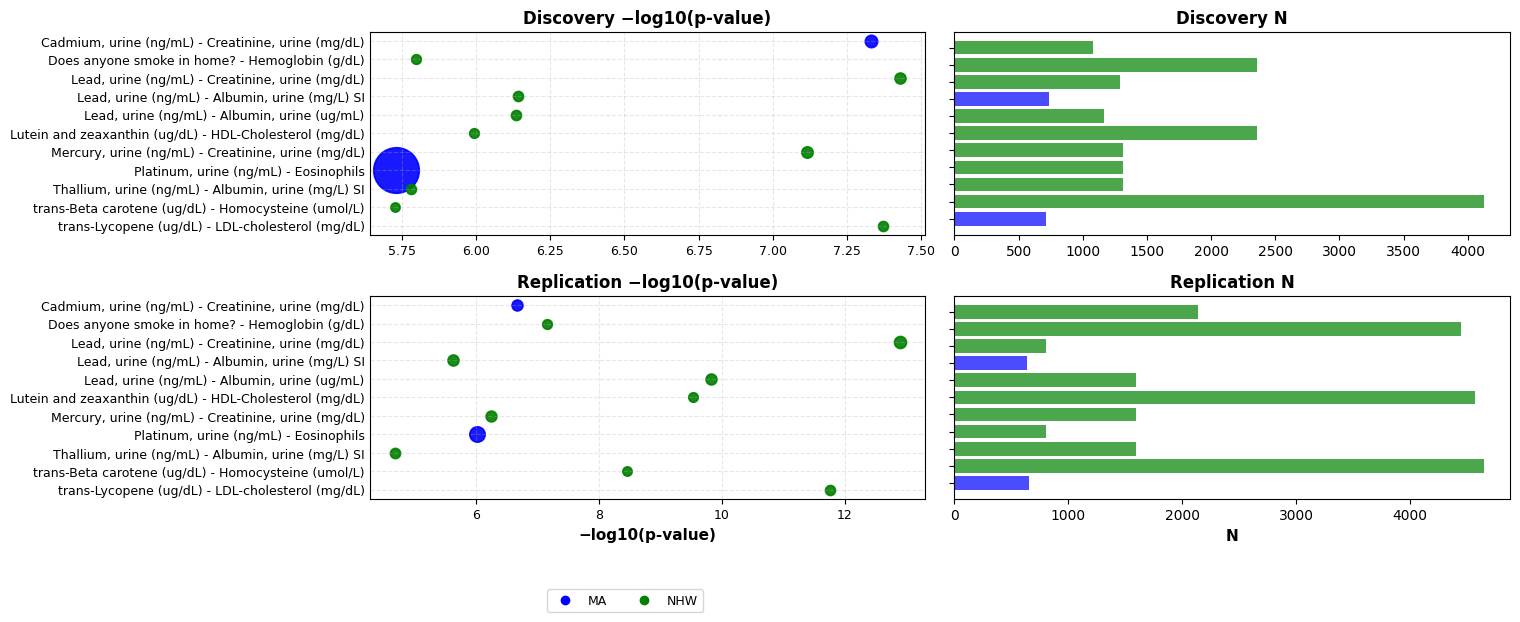

Saved figure to: /Users/nikkipalmiero/Documents/PhEWAS_manuscript/stratified_dotplot_withN_2x2_strataColors_labels_grid.png


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# ======== LOAD DATA ========

path = "/Users/nikkipalmiero/Documents/PhEWAS_manuscript/strata_overlap_table.csv"
df = pd.read_csv(path)

# Clean column names
df = df.rename(columns=lambda c: c.strip().replace(" ", "_"))

# Convert betas to numeric (handles "NA")
df["Replication_Beta"] = pd.to_numeric(df["Replication_Beta"], errors="coerce")
df["Discovery_Beta"]   = pd.to_numeric(df["Discovery_Beta"], errors="coerce")

# Clean phenotype names: remove "number" and "Direct"
df["Phenotype"] = (
    df["Phenotype"]
      .str.replace(r"\bnumber\b", "", case=True, regex=True)
      .str.replace(r"\bDirect\b", "", case=True, regex=True)
      .str.replace(r"\bdirect\b", "", case=True, regex=True)
      .str.replace("  ", " ")
      .str.strip()
)

# ======== FILTER: ONLY 'No' IN REPLICATED_FROM_ORIGINAL_DATASET ========

# Keep associations that are significant in both discovery and replication
sig = df[
    (df["Discovery_Bonferroni_pvalue"] < 0.05) &
    (df["Replication_Bonferroni_pvalue"] < 0.05)
].copy()

# Only those that are *not* replicated in the original dataset
sig = sig[sig["Replicated_from_Original_Dataset"].astype(str).str.upper() == "NO"].copy()

# Same direction (unless LRT)
disc = sig["Discovery_Beta"]
rep  = sig["Replication_Beta"]
same_dir = (disc * rep > 0) | disc.isna() | rep.isna()
sig = sig[same_dir].copy()

# ======== USE −log10 P-VALUES ========

sig["neglogP_disc"] = -np.log10(sig["Discovery_Raw_Pvalue"])
sig["neglogP_rep"]  = -np.log10(sig["Replication_Raw_pvalue"])

# ======== BUILD LABEL + ORDERING ========

# Exposure - Phenotype (no arrow)
sig["pair_label"] = sig["Exposure"] + " - " + sig["Phenotype"]

# Order by exposure, then discovery strength
sig = sig.sort_values(["Exposure", "neglogP_disc"], ascending=[True, False])

unique_pairs = sig["pair_label"].unique()
pair_to_idx = {p: i for i, p in enumerate(unique_pairs)}
sig["y"] = sig["pair_label"].map(pair_to_idx)

# ======== COLOR / SIZE / STYLE ========

strata_colors = {"MA": "blue", "NHW": "green", "NHB": "red"}

abs_beta = sig["Replication_Beta"].abs()
max_abs_beta = np.nanmax(abs_beta) if np.any(~np.isnan(abs_beta)) else 1.0

def point_size(beta):
    if np.isnan(beta):
        return 40
    return 40 + 80 * (abs(beta) / max_abs_beta)

# N columns
disc_N = sig["Discovery_N"]
rep_N  = sig["Replication_N"]

disc_bar_colors = [strata_colors.get(s, "gray") for s in sig["Strata"]]
rep_bar_colors  = [strata_colors.get(s, "gray") for s in sig["Strata"]]

# ======== PLOT: 2x2 GRID ========

fig, axes = plt.subplots(
    2, 2,
    figsize=(18, max(6, len(unique_pairs) * 0.3)),
    sharey=False
)

ax_disc_p, ax_disc_N = axes[0]
ax_rep_p,  ax_rep_N  = axes[1]

# --- Discovery panel (−log10(p)) ---
for _, row in sig.iterrows():
    color = strata_colors.get(row["Strata"], "gray")
    y     = row["y"]
    beta  = row["Discovery_Beta"]

    ax_disc_p.scatter(
        row["neglogP_disc"], y,
        s=point_size(beta),
        edgecolor=color,
        facecolors=("none" if np.isnan(beta) else color),
        linewidth=1.3,
        alpha=0.9
    )

# --- Replication panel (−log10(p)) ---
for _, row in sig.iterrows():
    color = strata_colors.get(row["Strata"], "gray")
    y     = row["y"]
    beta  = row["Replication_Beta"]

    ax_rep_p.scatter(
        row["neglogP_rep"], y,
        s=point_size(beta),
        edgecolor=color,
        facecolors=("none" if np.isnan(beta) else color),
        linewidth=1.3,
        alpha=0.9
    )

# --- Discovery N panel (top-right) ---
ax_disc_N.barh(sig["y"], disc_N, alpha=0.7, color=disc_bar_colors)

# --- Replication N panel (bottom-right) ---
ax_rep_N.barh(sig["y"], rep_N, alpha=0.7, color=rep_bar_colors)

# ======== AXES & LABELS (BOTTOM ROW ONLY; symmetric) ========

yticks = np.arange(len(unique_pairs))

# Left panels: p-value plots
ax_disc_p.set_yticks(yticks)
ax_disc_p.set_yticklabels(unique_pairs, fontsize=9)
ax_disc_p.invert_yaxis()

ax_rep_p.set_yticks(yticks)
ax_rep_p.set_yticklabels(unique_pairs, fontsize=9)
ax_rep_p.invert_yaxis()

# Right panels: N bar plots (no y labels)
ax_disc_N.set_yticks(yticks)
ax_disc_N.set_yticklabels([])

ax_rep_N.set_yticks(yticks)
ax_rep_N.set_yticklabels([])

# Titles
ax_disc_p.set_title("Discovery −log10(p-value)", fontsize=12, fontweight="bold")
ax_rep_p.set_title("Replication −log10(p-value)", fontsize=12, fontweight="bold")
ax_disc_N.set_title("Discovery N", fontsize=12, fontweight="bold")
ax_rep_N.set_title("Replication N", fontsize=12, fontweight="bold")

# X-axis labels (BOTTOM ROW ONLY)
ax_disc_p.set_xlabel("")
ax_disc_N.set_xlabel("")
ax_rep_p.set_xlabel("−log10(p-value)", fontsize=11, fontweight="bold")
ax_rep_N.set_xlabel("N", fontsize=11, fontweight="bold")

# ======== GRID LINES ON BOTH AXES ========

for ax in [ax_disc_p, ax_rep_p]:
    ax.grid(axis="both", linestyle="--", alpha=0.3)
    ax.tick_params(axis="x", labelsize=9)
    ax.tick_params(axis="y", length=0)  # optional cleaner style

# ======== LEGEND ========

legend_handles = [
    mlines.Line2D([], [], color="blue",  marker='o', linestyle='None', label="MA"),
    mlines.Line2D([], [], color="green", marker='o', linestyle='None', label="NHW"),
]

fig.legend(
    handles=legend_handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.04),
    ncol=2,
    fontsize=9,
    frameon=True
)

plt.tight_layout(rect=[0.15, 0.06, 1, 1])

save_path = "/Users/nikkipalmiero/Documents/PhEWAS_manuscript/stratified_dotplot_withN_2x2_strataColors_labels_grid.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved figure to:", save_path)


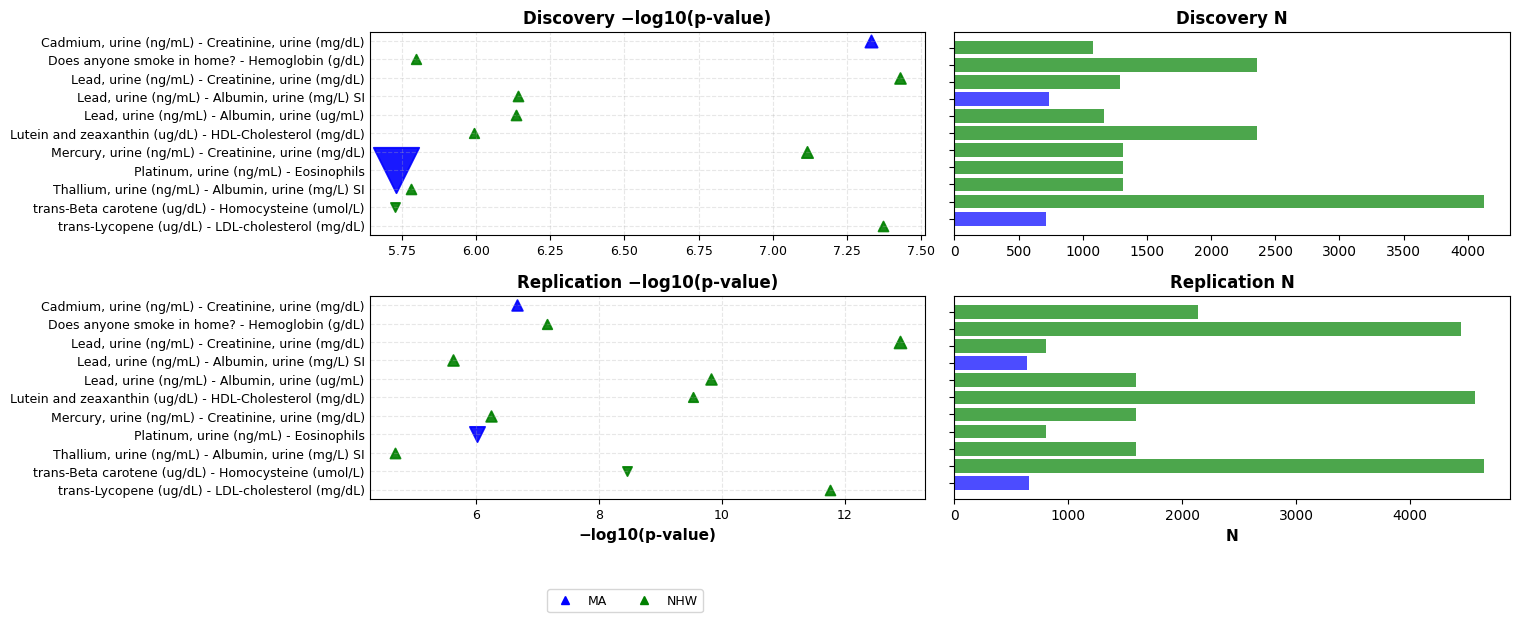

Saved figure to: /Users/nikkipalmiero/Documents/PhEWAS_manuscript/stratified_dotplot_withN_2x2_strataColors_labels_grid.png


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# ======== LOAD DATA ========

path = "/Users/nikkipalmiero/Documents/PhEWAS_manuscript/strata_overlap_table.csv"
df = pd.read_csv(path)

# Clean column names
df = df.rename(columns=lambda c: c.strip().replace(" ", "_"))

# Convert betas to numeric (handles "NA")
df["Replication_Beta"] = pd.to_numeric(df["Replication_Beta"], errors="coerce")
df["Discovery_Beta"]   = pd.to_numeric(df["Discovery_Beta"], errors="coerce")

# Clean phenotype names: remove "number" and "Direct"
df["Phenotype"] = (
    df["Phenotype"]
      .str.replace(r"\bnumber\b", "", case=True, regex=True)
      .str.replace(r"\bDirect\b", "", case=True, regex=True)
      .str.replace(r"\bdirect\b", "", case=True, regex=True)
      .str.replace("  ", " ")
      .str.strip()
)

# ======== FILTER: ONLY 'No' IN REPLICATED_FROM_ORIGINAL_DATASET ========

# Keep associations that are significant in both discovery and replication
sig = df[
    (df["Discovery_Bonferroni_pvalue"] < 0.05) &
    (df["Replication_Bonferroni_pvalue"] < 0.05)
].copy()

# Only those that are *not* replicated in the original dataset
sig = sig[sig["Replicated_from_Original_Dataset"].astype(str).str.upper() == "NO"].copy()

# Same direction (unless LRT)
disc = sig["Discovery_Beta"]
rep  = sig["Replication_Beta"]
same_dir = (disc * rep > 0) | disc.isna() | rep.isna()
sig = sig[same_dir].copy()

# ======== USE −log10 P-VALUES ========

sig["neglogP_disc"] = -np.log10(sig["Discovery_Raw_Pvalue"])
sig["neglogP_rep"]  = -np.log10(sig["Replication_Raw_pvalue"])

# ======== BUILD LABEL + ORDERING ========

# Exposure - Phenotype (no arrow)
sig["pair_label"] = sig["Exposure"] + " - " + sig["Phenotype"]

# Order by exposure, then discovery strength
sig = sig.sort_values(["Exposure", "neglogP_disc"], ascending=[True, False])

unique_pairs = sig["pair_label"].unique()
pair_to_idx = {p: i for i, p in enumerate(unique_pairs)}
sig["y"] = sig["pair_label"].map(pair_to_idx)

# ======== COLOR / SIZE / STYLE ========

strata_colors = {"MA": "blue", "NHW": "green", "NHB": "red"}

abs_beta = sig["Replication_Beta"].abs()
max_abs_beta = np.nanmax(abs_beta) if np.any(~np.isnan(abs_beta)) else 1.0

def point_size(beta):
    if np.isnan(beta):
        return 40
    return 40 + 80 * (abs(beta) / max_abs_beta)

def tri_marker(beta):
    """Up triangle if beta>0, down triangle if beta<0, up (hollow) if NA."""
    if np.isnan(beta):
        return "^"
    return "^" if beta > 0 else "v"

# N columns
disc_N = sig["Discovery_N"]
rep_N  = sig["Replication_N"]

disc_bar_colors = [strata_colors.get(s, "gray") for s in sig["Strata"]]
rep_bar_colors  = [strata_colors.get(s, "gray") for s in sig["Strata"]]

# ======== PLOT: 2x2 GRID ========

fig, axes = plt.subplots(
    2, 2,
    figsize=(18, max(6, len(unique_pairs) * 0.3)),
    sharey=False
)

ax_disc_p, ax_disc_N = axes[0]
ax_rep_p,  ax_rep_N  = axes[1]

# --- Discovery panel (−log10(p)) ---
for _, row in sig.iterrows():
    color = strata_colors.get(row["Strata"], "gray")
    y     = row["y"]
    beta  = row["Discovery_Beta"]

    ax_disc_p.scatter(
        row["neglogP_disc"], y,
        s=point_size(beta),
        marker=tri_marker(beta),               # <-- triangles by sign
        edgecolor=color,
        facecolors=("none" if np.isnan(beta) else color),
        linewidth=1.3,
        alpha=0.9
    )

# --- Replication panel (−log10(p)) ---
for _, row in sig.iterrows():
    color = strata_colors.get(row["Strata"], "gray")
    y     = row["y"]
    beta  = row["Replication_Beta"]

    ax_rep_p.scatter(
        row["neglogP_rep"], y,
        s=point_size(beta),
        marker=tri_marker(beta),               # <-- triangles by sign
        edgecolor=color,
        facecolors=("none" if np.isnan(beta) else color),
        linewidth=1.3,
        alpha=0.9
    )

# --- Discovery N panel (top-right) ---
ax_disc_N.barh(sig["y"], disc_N, alpha=0.7, color=disc_bar_colors)

# --- Replication N panel (bottom-right) ---
ax_rep_N.barh(sig["y"], rep_N, alpha=0.7, color=rep_bar_colors)

# ======== AXES & LABELS (BOTTOM ROW ONLY; symmetric) ========

yticks = np.arange(len(unique_pairs))

# Left panels: p-value plots
ax_disc_p.set_yticks(yticks)
ax_disc_p.set_yticklabels(unique_pairs, fontsize=9)
ax_disc_p.invert_yaxis()

ax_rep_p.set_yticks(yticks)
ax_rep_p.set_yticklabels(unique_pairs, fontsize=9)
ax_rep_p.invert_yaxis()

# Right panels: N bar plots (no y labels)
ax_disc_N.set_yticks(yticks)
ax_disc_N.set_yticklabels([])

ax_rep_N.set_yticks(yticks)
ax_rep_N.set_yticklabels([])

# Titles
ax_disc_p.set_title("Discovery −log10(p-value)", fontsize=12, fontweight="bold")
ax_rep_p.set_title("Replication −log10(p-value)", fontsize=12, fontweight="bold")
ax_disc_N.set_title("Discovery N", fontsize=12, fontweight="bold")
ax_rep_N.set_title("Replication N", fontsize=12, fontweight="bold")

# X-axis labels (BOTTOM ROW ONLY)
ax_disc_p.set_xlabel("")
ax_disc_N.set_xlabel("")
ax_rep_p.set_xlabel("−log10(p-value)", fontsize=11, fontweight="bold")
ax_rep_N.set_xlabel("N", fontsize=11, fontweight="bold")

# ======== GRID LINES ON BOTH AXES ========

for ax in [ax_disc_p, ax_rep_p]:
    ax.grid(axis="both", linestyle="--", alpha=0.3)
    ax.tick_params(axis="x", labelsize=9)
    ax.tick_params(axis="y", length=0)

# ======== LEGEND ========

legend_handles = [
    mlines.Line2D([], [], color="blue",  marker='^', linestyle='None', label="MA"),
    mlines.Line2D([], [], color="green", marker='^', linestyle='None', label="NHW"),
    # add if you want:
    # mlines.Line2D([], [], color="red",   marker='^', linestyle='None', label="NHB"),
]

fig.legend(
    handles=legend_handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.04),
    ncol=len(legend_handles),
    fontsize=9,
    frameon=True
)

plt.tight_layout(rect=[0.15, 0.06, 1, 1])

save_path = "/Users/nikkipalmiero/Documents/PhEWAS_manuscript/stratified_dotplot_withN_2x2_strataColors_labels_grid.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved figure to:", save_path)


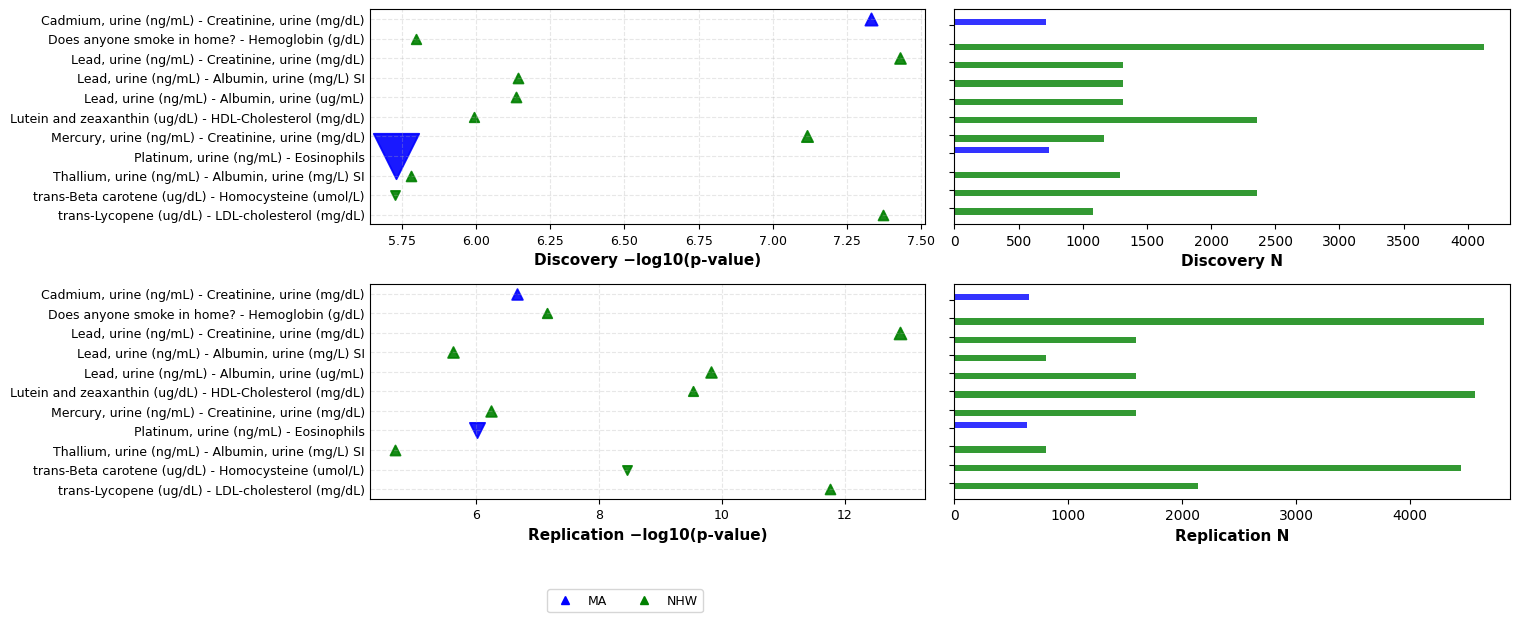

Saved figure to: /Users/nikkipalmiero/Documents/PhEWAS_manuscript/stratified_dotplot_withN_2x2_strataColors_labels_grid.png


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# ======== LOAD DATA ========

path = "/Users/nikkipalmiero/Documents/PhEWAS_manuscript/strata_overlap_table.csv"
df = pd.read_csv(path)

# Clean column names
df = df.rename(columns=lambda c: c.strip().replace(" ", "_"))

# Convert betas to numeric (handles "NA")
df["Replication_Beta"] = pd.to_numeric(df["Replication_Beta"], errors="coerce")
df["Discovery_Beta"]   = pd.to_numeric(df["Discovery_Beta"], errors="coerce")

# Clean phenotype names: remove "number" and "Direct"
df["Phenotype"] = (
    df["Phenotype"]
      .str.replace(r"\bnumber\b", "", case=True, regex=True)
      .str.replace(r"\bDirect\b", "", case=True, regex=True)
      .str.replace(r"\bdirect\b", "", case=True, regex=True)
      .str.replace("  ", " ")
      .str.strip()
)

# ======== FILTER ========

sig = df[
    (df["Discovery_Bonferroni_pvalue"] < 0.05) &
    (df["Replication_Bonferroni_pvalue"] < 0.05)
].copy()

sig = sig[sig["Replicated_from_Original_Dataset"].astype(str).str.upper() == "NO"].copy()

disc = sig["Discovery_Beta"]
rep  = sig["Replication_Beta"]
same_dir = (disc * rep > 0) | disc.isna() | rep.isna()
sig = sig[same_dir].copy()

# ======== USE −log10 P-VALUES ========

sig["neglogP_disc"] = -np.log10(sig["Discovery_Raw_Pvalue"])
sig["neglogP_rep"]  = -np.log10(sig["Replication_Raw_pvalue"])

# ======== BUILD LABEL + ORDERING ========

sig["pair_label"] = sig["Exposure"] + " - " + sig["Phenotype"]
sig = sig.sort_values(["Exposure", "neglogP_disc"], ascending=[True, False])

unique_pairs = sig["pair_label"].unique()
pair_to_idx = {p: i for i, p in enumerate(unique_pairs)}
sig["y"] = sig["pair_label"].map(pair_to_idx)

# ======== COLOR / SIZE / MARKER STYLE ========

strata_colors = {"MA": "blue", "NHW": "green", "NHB": "red"}

abs_beta = sig["Replication_Beta"].abs()
max_abs_beta = np.nanmax(abs_beta) if np.any(~np.isnan(abs_beta)) else 1.0

def point_size(beta):
    if np.isnan(beta):
        return 40
    return 40 + 80 * (abs(beta) / max_abs_beta)

def tri_marker(beta):
    if np.isnan(beta):
        return "^"
    return "^" if beta > 0 else "v"

# ======== BUILD BAR DATA FOR BOTH STRATA (DODGED, NO OVERPLOT) ========

bar_strata = ["MA", "NHW"]  # add "NHB" if you want
bars = (sig[sig["Strata"].isin(bar_strata)]
        .drop_duplicates(subset=["pair_label", "Strata"])
        .copy())

bars["y"] = bars["pair_label"].map(pair_to_idx)

bar_height = 0.35
offsets = {"MA": -bar_height/2, "NHW": +bar_height/2}
bars["y_bar"] = bars.apply(lambda r: r["y"] + offsets.get(r["Strata"], 0), axis=1)

bars["bar_color"] = bars["Strata"].map(strata_colors).fillna("gray")

# ======== PLOT: 2x2 GRID ========

fig, axes = plt.subplots(
    2, 2,
    figsize=(18, max(6, len(unique_pairs) * 0.3)),
    sharey=False
)

ax_disc_p, ax_disc_N = axes[0]
ax_rep_p,  ax_rep_N  = axes[1]

# --- Discovery panel (−log10(p)) ---
for _, row in sig.iterrows():
    color = strata_colors.get(row["Strata"], "gray")
    y     = row["y"]
    beta  = row["Discovery_Beta"]

    ax_disc_p.scatter(
        row["neglogP_disc"], y,
        s=point_size(beta),
        marker=tri_marker(beta),
        edgecolor=color,
        facecolors=("none" if np.isnan(beta) else color),
        linewidth=1.3,
        alpha=0.9
    )

# --- Replication panel (−log10(p)) ---
for _, row in sig.iterrows():
    color = strata_colors.get(row["Strata"], "gray")
    y     = row["y"]
    beta  = row["Replication_Beta"]

    ax_rep_p.scatter(
        row["neglogP_rep"], y,
        s=point_size(beta),
        marker=tri_marker(beta),
        edgecolor=color,
        facecolors=("none" if np.isnan(beta) else color),
        linewidth=1.3,
        alpha=0.9
    )

# --- Discovery N panel (top-right) ---
ax_disc_N.barh(bars["y_bar"], bars["Discovery_N"],
               height=bar_height, alpha=0.8, color=bars["bar_color"])

# --- Replication N panel (bottom-right) ---
ax_rep_N.barh(bars["y_bar"], bars["Replication_N"],
              height=bar_height, alpha=0.8, color=bars["bar_color"])

# ======== AXES & LABELS ========

yticks = np.arange(len(unique_pairs))

ax_disc_p.set_yticks(yticks)
ax_disc_p.set_yticklabels(unique_pairs, fontsize=9)
ax_disc_p.invert_yaxis()

ax_rep_p.set_yticks(yticks)
ax_rep_p.set_yticklabels(unique_pairs, fontsize=9)
ax_rep_p.invert_yaxis()

ax_disc_N.set_yticks(yticks)
ax_disc_N.set_yticklabels([])
ax_disc_N.invert_yaxis()

ax_rep_N.set_yticks(yticks)
ax_rep_N.set_yticklabels([])
ax_rep_N.invert_yaxis()

#ax_disc_p.set_title("Discovery −log10(p-value)", fontsize=12, fontweight="bold")
#ax_rep_p.set_title("Replication −log10(p-value)", fontsize=12, fontweight="bold")
#ax_disc_N.set_title("Discovery N", fontsize=12, fontweight="bold")
#ax_rep_N.set_title("Replication N", fontsize=12, fontweight="bold")

# ======== X-AXIS LABELS (NO PANEL TITLES) ========

ax_disc_p.set_xlabel("Discovery −log10(p-value)", fontsize=11, fontweight="bold")
ax_rep_p.set_xlabel("Replication −log10(p-value)", fontsize=11, fontweight="bold")

ax_disc_N.set_xlabel("Discovery N", fontsize=11, fontweight="bold")
ax_rep_N.set_xlabel("Replication N", fontsize=11, fontweight="bold")

for ax in [ax_disc_p, ax_rep_p]:
    ax.grid(axis="both", linestyle="--", alpha=0.3)
    ax.tick_params(axis="x", labelsize=9)
    ax.tick_params(axis="y", length=0)

# ======== LEGEND ========

legend_handles = [
    mlines.Line2D([], [], color="blue",  marker='^', linestyle='None', label="MA"),
    mlines.Line2D([], [], color="green", marker='^', linestyle='None', label="NHW"),
]

fig.legend(
    handles=legend_handles,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.04),
    ncol=len(legend_handles),
    fontsize=9,
    frameon=True
)

plt.tight_layout(rect=[0.15, 0.06, 1, 1])

save_path = "/Users/nikkipalmiero/Documents/PhEWAS_manuscript/stratified_dotplot_withN_2x2_strataColors_labels_grid.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved figure to:", save_path)
